In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

In [2]:
from urllib.request import urlopen
import plotly.express as px
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd


In [25]:
bf_geo = pd.read_csv('data/bigfoot_with_county.csv')
bf_geo['FIPS County'] = [str(i).zfill(5) for i in bf_geo['FIPS County']]

bf_geo.head(1)

,Unnamed: 0,submission_date,submission_title,observations,classification,nearest_town,state,county,time_and_condition,other_witness,season,State,County Name,FIPS State,FIPS County
0,0,"Submitted by witness on Saturday, November...",Snowmobiler has encounter in deep snow near Po...,I and two of my friends were bored one night s...,(Class A),NEAREST TOWN: Anchorage / Hillside,Alaska,Anchorage,TIME AND CONDITIONS: Middle of the night. The ...,OTHER WITNESSES: My two friends were snowmachi...,SEASON: Winter,Alaska,Anchorage,2,00020


In [30]:
bf_county_count = bf_geo.groupby(['FIPS County']).count()[['observations']].reset_index()
bf_county_count

,FIPS County,observations
0,00001,56
1,00003,68
2,00005,135
3,00007,100
4,00009,76
...,...,...
177,00481,2
178,00497,1
179,00499,3
180,00550,2


## Create visualizations
- Create maps of COVID incidence rates by county and HIV prevalence by county. While incidence and prevalence are two different measures, in this case each may be the best metric of the underlying epidemic. 
- Fortunately, HIV is much less common than COVID, so incidence numbers are smaller--even nonexistent (or at least not reported) in many counties. Prevalence--while not perfect--is the most accurate measure of the penetration of the disease. The downsides are that it doesn't necessarily indicate where the disease was contracted since people are mobile. 
- For COVID, incidence is the only measure that makes sense since it is not a persistent illness. 
- Scatter matrix of COVID by HIV. The issue with the data that the scatter matrix demonstrates clearly is that the regional strength of signal may not translate down to the county level. I.e. while the map suggests a strong geographic trend, the trend may not be as apparent at the county level. Perhaps there's too much point variation. One approach to addressing this problem could be to regionalize the data by creating KNN Regressor predictions. The approach would to calculate a KNN mapping of an epidemic predictor from the covid data and separately for the hiv data, and then compare each of the KNN mappings. This approach was taken a KNN of 10 to 'regionalize' the hiv data and the covid data. These maps are presented after the original maps.


In [31]:
fig = px.choropleth_mapbox(bf_county_count, geojson=counties, locations='FIPS County', color='observations',
                           color_continuous_scale="Viridis",
#                            range_color=(0, 140),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'observations':'observations'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/bigfoot_map.png")
fig.write_html('img/bigfoot.html', auto_open=True)


### KNN predictions and generate new visualizations

In [15]:
from sklearn.neighbors import KNeighborsRegressor
X = hiv_cov[['Lat', 'Long_']]

y_covid = hiv_cov['COVID_Incidence_Rate']
covid_KNN = KNeighborsRegressor(n_neighbors=10)
covid_KNN.fit(X, y_covid)
covid_yhat = covid_KNN.predict(X)

y_hiv = hiv_cov['HIVprevalence']
hiv_KNN = KNeighborsRegressor(n_neighbors=10)
hiv_KNN.fit(X, y_hiv)
hiv_yhat = hiv_KNN.predict(X)


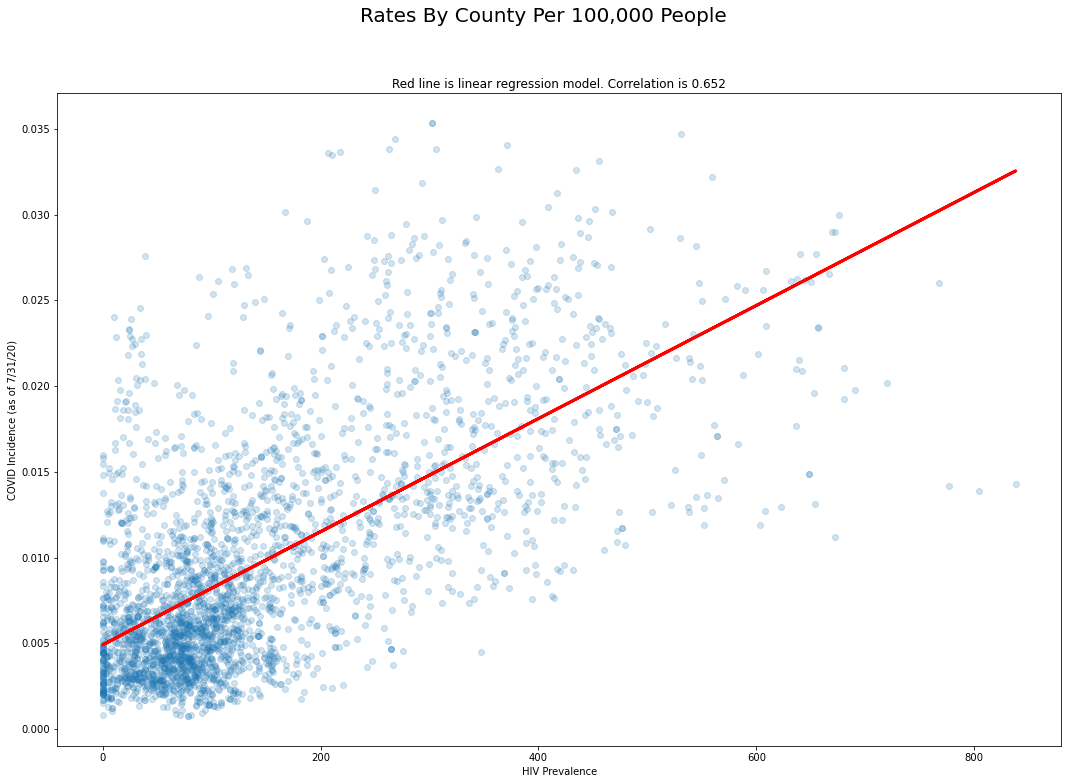

In [36]:
fig, ax = plt.subplots(figsize = (18, 12))
X = hiv_yhat.reshape(-1,1)
y = covid_yhat
model = LinearRegression()
model.fit(X, y)
yhat = model.predict(X)
ax.plot(X, yhat, linewidth = 3, color = 'r')
ax.scatter(hiv_yhat, covid_yhat, alpha = 0.2)
# ax.scatter(np.log(hiv_cov['HIVprevalence']), np.log(hiv_cov['COVID_Incidence_Rate']), alpha = 0.2)
ax.set_xlabel('HIV Prevalence')
ax.set_ylabel('COVID Incidence (as of 7/31/20)')
fig.suptitle('Rates By County Per 100,000 People', size=20)
ax.set_title(f'Red line is linear regression model. Correlation is {pd.Series(hiv_yhat).corr(pd.Series(covid_yhat)):.3}')
plt.savefig('img/prediction-scatterplot.png')


In [28]:
hiv_cov['covid_epidemic_prediction'] = covid_yhat
hiv_cov['hiv_epidemic_prediction'] = hiv_yhat

In [37]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='covid_epidemic_prediction',
                           color_continuous_scale="Viridis",
                           range_color=(0, 0.022),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'covid_epidemic_prediction':'COVID Incidence Prediction Based on Neighboring Counties'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/covid_epidemic_prediction.png")
fig.write_html('img/covid_epidemic_prediction.html', auto_open=True)

In [38]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='hiv_epidemic_prediction',
                           color_continuous_scale="Viridis",
                           range_color=(0, 325),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'hiv_epidemic_prediction':'HIV Prevalence Prediction Based on Neighboring Counties'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/hiv_epidemic_prediction.png")
fig.write_html('img/hiv_epidemic_prediction.html', auto_open=True)

## Results
- Regionalization improved the correlation of the maps. 
- 